## Prepare Training Dataset

In [ ]:
path = "/content/drive/MyDrive/AmeXio"

In [ ]:
import pandas as pd
import json
import os
from collections import Counter

In [ ]:
# === PRE-PROCESS CONFIGURATION ===
INPUT_CSV = "path/to/raw/in.csv" # Must have _value and _time column
SEQUENCE_LENGTH = 20
OUTPUT_DIR = "path/to/output/dir/"

import argparse
import torch

from bert_pytorch.dataset import WordVocab
from bert_pytorch import Predictor, Trainer, Processor
from bert_pytorch.dataset.utils import seed_everything

options = dict()
options['device'] = 'cuda' if torch.cuda.is_available() else 'cpu'
options["output_dir"] = OUTPUT_DIR
options["model_dir"] = options["output_dir"] + "bert/"
options["model_path"] = options["model_dir"] + "best_bert.pth"
options["train_vocab"] = options["output_dir"] + "train"
options["vocab_path"] = options["output_dir"] + "vocab.pkl"  # pickle file

options["drain_config"] = "/path/to/drain/config"
options["drain_state"] = "/path/to/drain/state"

options["window_size"] = 128
options["adaptive_window"] = True
options["seq_len"] = SEQUENCE_LENGTH
options["max_len"] = 512 # for position embedding
options["min_len"] = 10
options["mask_ratio"] = 0.65
# sample ratio
options["train_ratio"] = 0.7
options["test_ratio"] = 0.25
options["valid_ratio"] = 0.05

# features
options["is_logkey"] = True
options["is_time"] = False

options["hypersphere_loss"] = True
options["hypersphere_loss_test"] = False

options["scale"] = None # MinMaxScaler()
options["scale_path"] = options["model_dir"] + "scale.pkl"

# model
options["hidden"] = 256 # embedding size
options["layers"] = 4
options["attn_heads"] = 4

options["epochs"] = 100
options["n_epochs_stop"] = 10
options["batch_size"] = 32

options["corpus_lines"] = None
options["on_memory"] = True
options["num_workers"] = 5
options["lr"] = 1e-3
options["adam_beta1"] = 0.9
options["adam_beta2"] = 0.999
options["adam_weight_decay"] = 0.00
options["with_cuda"]= True
options["cuda_devices"] = None
options["log_freq"] = None

# predict
options["num_candidates"] = 6
options["gaussian_mean"] = 0
options["gaussian_std"] = 1

seed_everything(seed=1234)

if not os.path.exists(options['model_dir']):
    os.makedirs(options['model_dir'], exist_ok=True)

print("device", options["device"])
print("features logkey:{} time: {}\n".format(options["is_logkey"], options["is_time"]))
print("mask ratio", options["mask_ratio"])

device cuda
features logkey:True time: False

mask ratio 0.65


In [ ]:
def process():
    proc = Processor(options)
    proc.preprocess(INPUT_CSV)
    proc.process(SEQUENCE_LENGTH)

def train():
    Trainer(options).train()

def predict(mean=0, std=1):
    options["gaussian_mean"] = mean
    options["gaussian_std"] = std

    Predictor(options).predict()

def vocab(vocab_size=None, encoding="utf-8", min_freq=1):
    with open(options["train_vocab"], "r", encoding=encoding) as f:
        texts = f.readlines()
        print(texts)

    vocab = WordVocab(texts, max_size=vocab_size, min_freq=min_freq)
    vocab.save_vocab(options["vocab_path"])

In [ ]:
process()

In [ ]:
vocab()

['E7 E37 E4 E4 E41 E4 E4 E4 E4 E4 E4 E35 E35 E4 E35 E4 E4 E4 E4 E4 E4 E4 E4 E4 E4 E4 E40 E111 E4 E4 E7 E37 E4 E4 E4 E4 E4 E4 E4 E4 E4 E4 E4 E4 E4 E4 E4 E4 E4 E4\n', 'E4 E20 E4 E4 E4 E4 E20 E4 E35 E9 E72 E9 E48 E48 E64 E64 E64 E64 E37 E37 E64 E64 E64 E7 E7 E7 E4 E50 E37 E9 E49 E4 E4 E12 E4 E9 E4 E4 E28 E4 E9 E149 E29 E29 E7 E7 E37 E7 E37 E7\n', 'E101 E88 E101 E88 E4 E9 E4 E101 E88 E88 E101 E4 E4 E4 E88 E101 E88 E109 E49 E101 E88 E101 E35 E35 E149 E29 E29 E101 E88 E88 E101 E101 E101 E88 E4 E92 E9 E8 E9 E35 E35 E8 E88 E101 E101 E86 E35 E35 E4 E4\n', 'E4 E4 E4 E4 E7 E7 E4 E9 E9 E18 E18 E18 E9 E9 E8 E4 E9 E37 E37 E7 E4 E4 E4 E9 E8 E9 E4 E4 E4 E8 E49 E8 E74 E7 E37 E7 E7 E7 E37 E37 E37 E37 E7 E37 E7 E37 E7 E37 E7 E37\n', 'E37 E7 E7 E7 E37 E7 E37 E37 E7 E98 E22 E7 E7 E37 E37 E7 E37 E37 E7 E37 E7 E7 E37 E7 E37 E7 E7 E37 E37 E37 E7 E86 E37 E86 E37 E7 E108 E7 E37 E7 E37 E7 E37 E7 E7 E37 E4 E7 E37 E7\n', 'E4 E9 E20 E4 E46 E4 E4 E9 E4 E8 E4 E4 E4 E19 E9 E89 E40 E4 E4 E20 E4 E9 E19 E4 E20 E4 E4 E9 E

100%|██████████| 2892/2892 [00:00<00:00, 77931.29it/s]


Save options parameters
Loading vocab /content/drive/MyDrive/AmeXio/output/logbert/ApplicationServer_nlxdsmcv38/vocab.pkl
vocab Size:  106

Loading Train Dataset
before filtering short session
train size  2603
valid size  289


100%|██████████| 2892/2892 [00:00<00:00, 54585.22it/s]

Num of train seqs 2603
Num of valid seqs 289

Loading valid Dataset
Creating Dataloader
Building BERT model


Creating BERT Trainer
Total Parameters: 2164331
Training Start


start calculate center


/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
  0%|          | 0/81 [00:00<?, ?it/s]/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the lis

Epoch: 0 | phase: train, loss=5.091983365423886
logkey loss: 4.968437247806126, hyper loss: 1.23546106579863



/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy

Epoch: 0 | phase: valid, loss=4.643303023444282
logkey loss: 4.518547111087376, hyper loss: 1.247559176550971

Log saved
 Model Saved on: /content/drive/MyDrive/AmeXio/output/logbert/ApplicationServer_nlxdsmcv38/bert/best_bert.pth


start calculate center


  0%|          | 0/81 [00:00<?, ?it/s]/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the lis

Epoch: 1 | phase: train, loss=4.017190615336101
logkey loss: 3.889995801595994, hyper loss: 1.2719480181917733



/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy

Epoch: 1 | phase: valid, loss=3.568193197250366
logkey loss: 3.4328025446997747, hyper loss: 1.3539064195421007

Log saved
 Model Saved on: /content/drive/MyDrive/AmeXio/output/logbert/ApplicationServer_nlxdsmcv38/bert/best_bert.pth


start calculate center


  0%|          | 0/81 [00:00<?, ?it/s]/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the lis

Epoch: 2 | phase: train, loss=3.2365679858643333
logkey loss: 3.1116022681012567, hyper loss: 1.2496571481963734



/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy

Epoch: 2 | phase: valid, loss=3.0997803476121693
logkey loss: 2.9765514267815485, hyper loss: 1.232289367251926

Log saved
 Model Saved on: /content/drive/MyDrive/AmeXio/output/logbert/ApplicationServer_nlxdsmcv38/bert/best_bert.pth


start calculate center


/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy

Epoch: 3 | phase: train, loss=2.874014851487713
logkey loss: 2.7574876738183294, hyper loss: 1.1652716486542314



/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy

Epoch: 3 | phase: valid, loss=2.785810205671522
logkey loss: 2.6714812914530435, hyper loss: 1.143288877275255

Log saved
 Model Saved on: /content/drive/MyDrive/AmeXio/output/logbert/ApplicationServer_nlxdsmcv38/bert/best_bert.pth


start calculate center


  0%|          | 0/81 [00:00<?, ?it/s]/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the lis

Epoch: 4 | phase: train, loss=2.6636603908774292
logkey loss: 2.5543351467744806, hyper loss: 1.0932524689921626



/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy

Epoch: 4 | phase: valid, loss=2.654790269003974
logkey loss: 2.548923042085436, hyper loss: 1.0586720175213284

Log saved
 Model Saved on: /content/drive/MyDrive/AmeXio/output/logbert/ApplicationServer_nlxdsmcv38/bert/best_bert.pth


start calculate center


  0%|          | 0/81 [00:00<?, ?it/s]/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the lis

Epoch: 5 | phase: train, loss=2.5600458722055692
logkey loss: 2.462144648587262, hyper loss: 0.9790123421468853



/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy

Epoch: 5 | phase: valid, loss=2.5353797011905246
logkey loss: 2.439992083443536, hyper loss: 0.953876343038347

Log saved
 Model Saved on: /content/drive/MyDrive/AmeXio/output/logbert/ApplicationServer_nlxdsmcv38/bert/best_bert.pth


start calculate center


  0%|          | 0/81 [00:00<?, ?it/s]/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the lis

Epoch: 6 | phase: train, loss=2.448632698000213
logkey loss: 2.361938613432425, hyper loss: 0.8669408044697325



/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy

Epoch: 6 | phase: valid, loss=2.457233084572686
logkey loss: 2.3725289238823786, hyper loss: 0.847041666507721

Log saved
 Model Saved on: /content/drive/MyDrive/AmeXio/output/logbert/ApplicationServer_nlxdsmcv38/bert/best_bert.pth


start calculate center


  0%|          | 0/81 [00:00<?, ?it/s]/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the lis

Epoch: 7 | phase: train, loss=2.378524852387699
logkey loss: 2.300491365385644, hyper loss: 0.7803347971704271



/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy

Epoch: 7 | phase: valid, loss=2.4563663800557456
logkey loss: 2.3798532088597617, hyper loss: 0.7651312881045871

Log saved
 Model Saved on: /content/drive/MyDrive/AmeXio/output/logbert/ApplicationServer_nlxdsmcv38/bert/best_bert.pth


start calculate center


  0%|          | 0/81 [00:00<?, ?it/s]/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the lis

Epoch: 8 | phase: train, loss=2.335111035241021
logkey loss: 2.2632526129852106, hyper loss: 0.7185842505207768



/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy

Epoch: 8 | phase: valid, loss=2.4114651679992676
logkey loss: 2.341662791040209, hyper loss: 0.6980238689316643

Log saved
 Model Saved on: /content/drive/MyDrive/AmeXio/output/logbert/ApplicationServer_nlxdsmcv38/bert/best_bert.pth


start calculate center


/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
  0%|          | 0/81 [00:00<?, ?it/s]/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the lis

Epoch: 9 | phase: train, loss=2.2682631457293474
logkey loss: 2.2005934847725763, hyper loss: 0.6766966257566287



/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy

Epoch: 9 | phase: valid, loss=2.310824738608466
logkey loss: 2.2439391348097057, hyper loss: 0.6688560247421265

Log saved
 Model Saved on: /content/drive/MyDrive/AmeXio/output/logbert/ApplicationServer_nlxdsmcv38/bert/best_bert.pth


start calculate center


  0%|          | 0/81 [00:00<?, ?it/s]/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the lis

Epoch: 10 | phase: train, loss=2.2288139602284374
logkey loss: 2.1643133928746354, hyper loss: 0.6450056485187861



/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy

Epoch: 10 | phase: valid, loss=2.282993714014689
logkey loss: 2.21977170308431, hyper loss: 0.632219930489858

Log saved
 Model Saved on: /content/drive/MyDrive/AmeXio/output/logbert/ApplicationServer_nlxdsmcv38/bert/best_bert.pth


start calculate center


  0%|          | 0/81 [00:00<?, ?it/s]/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the lis

Epoch: 11 | phase: train, loss=2.166411308594692
logkey loss: 2.1043941724447555, hyper loss: 0.6201713644428017



/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy

Epoch: 11 | phase: valid, loss=2.2119927406311035
logkey loss: 2.151144438319736, hyper loss: 0.6084829436408149

Log saved
 Model Saved on: /content/drive/MyDrive/AmeXio/output/logbert/ApplicationServer_nlxdsmcv38/bert/best_bert.pth
best radius 13.24334492009434
Save best center /content/drive/MyDrive/AmeXio/output/logbert/ApplicationServer_nlxdsmcv38/bert/best_center.pt
save total dist:  /content/drive/MyDrive/AmeXio/output/logbert/ApplicationServer_nlxdsmcv38/bert/best_total_dist.pt


start calculate center


  0%|          | 0/81 [00:00<?, ?it/s]/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the lis

Epoch: 12 | phase: train, loss=2.1287914440955644
logkey loss: 2.0689855328312627, hyper loss: 0.5980591670966443



/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy

Epoch: 12 | phase: valid, loss=2.220206446117825
logkey loss: 2.16131681866116, hyper loss: 0.5888961884710524

Log saved


start calculate center


/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
  0%|          | 0/81 [00:00<?, ?it/s]/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the lis

Epoch: 13 | phase: train, loss=2.1055826478534274
logkey loss: 2.0480658404621077, hyper loss: 0.5751679605907865



/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy

Epoch: 13 | phase: valid, loss=2.202561100323995
logkey loss: 2.1466411352157593, hyper loss: 0.5591997967825996

Log saved
 Model Saved on: /content/drive/MyDrive/AmeXio/output/logbert/ApplicationServer_nlxdsmcv38/bert/best_bert.pth
best radius 12.744476766676785
Save best center /content/drive/MyDrive/AmeXio/output/logbert/ApplicationServer_nlxdsmcv38/bert/best_center.pt
save total dist:  /content/drive/MyDrive/AmeXio/output/logbert/ApplicationServer_nlxdsmcv38/bert/best_total_dist.pt


start calculate center


  0%|          | 0/81 [00:00<?, ?it/s]/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the lis

Epoch: 14 | phase: train, loss=2.0545525241781166
logkey loss: 1.9983933060257524, hyper loss: 0.5615921572402671



/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy

Epoch: 14 | phase: valid, loss=2.106558905707465
logkey loss: 2.0510318676630654, hyper loss: 0.5552700625525581

Log saved
 Model Saved on: /content/drive/MyDrive/AmeXio/output/logbert/ApplicationServer_nlxdsmcv38/bert/best_bert.pth
best radius 12.615890600543006
Save best center /content/drive/MyDrive/AmeXio/output/logbert/ApplicationServer_nlxdsmcv38/bert/best_center.pt
save total dist:  /content/drive/MyDrive/AmeXio/output/logbert/ApplicationServer_nlxdsmcv38/bert/best_total_dist.pt


start calculate center


  0%|          | 0/81 [00:00<?, ?it/s]/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the lis

Epoch: 15 | phase: train, loss=2.0151100085105424
logkey loss: 1.9605611238950564, hyper loss: 0.5454887549082438



/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy

Epoch: 15 | phase: valid, loss=2.1038630538516574
logkey loss: 2.0491517782211304, hyper loss: 0.5471125576231215

Log saved
 Model Saved on: /content/drive/MyDrive/AmeXio/output/logbert/ApplicationServer_nlxdsmcv38/bert/best_bert.pth
best radius 12.453139090321045
Save best center /content/drive/MyDrive/AmeXio/output/logbert/ApplicationServer_nlxdsmcv38/bert/best_center.pt
save total dist:  /content/drive/MyDrive/AmeXio/output/logbert/ApplicationServer_nlxdsmcv38/bert/best_total_dist.pt


start calculate center


  0%|          | 0/81 [00:00<?, ?it/s]/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the lis

Epoch: 16 | phase: train, loss=1.9940587694262282
logkey loss: 1.941173529919283, hyper loss: 0.5288525164863209



/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy

Epoch: 16 | phase: valid, loss=2.051412092314826
logkey loss: 1.9988858567343817, hyper loss: 0.5252622697088454

Log saved
 Model Saved on: /content/drive/MyDrive/AmeXio/output/logbert/ApplicationServer_nlxdsmcv38/bert/best_bert.pth
best radius 12.254418789693375
Save best center /content/drive/MyDrive/AmeXio/output/logbert/ApplicationServer_nlxdsmcv38/bert/best_center.pt
save total dist:  /content/drive/MyDrive/AmeXio/output/logbert/ApplicationServer_nlxdsmcv38/bert/best_total_dist.pt


start calculate center


  0%|          | 0/81 [00:00<?, ?it/s]/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the lis

Epoch: 17 | phase: train, loss=1.9756927122304468
logkey loss: 1.923785995554041, hyper loss: 0.5190672845016291



/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy

Epoch: 17 | phase: valid, loss=2.076477117008633
logkey loss: 2.0255442990197077, hyper loss: 0.5093280937936571

Log saved


start calculate center


  0%|          | 0/81 [00:00<?, ?it/s]/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the lis

Epoch: 18 | phase: train, loss=1.9396743583090512
logkey loss: 1.8887507606435705, hyper loss: 0.5092360587031753



/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy

Epoch: 18 | phase: valid, loss=2.03248749838935
logkey loss: 1.9823386139339871, hyper loss: 0.5014889538288116

Log saved
 Model Saved on: /content/drive/MyDrive/AmeXio/output/logbert/ApplicationServer_nlxdsmcv38/bert/best_bert.pth
best radius 12.019274607691319
Save best center /content/drive/MyDrive/AmeXio/output/logbert/ApplicationServer_nlxdsmcv38/bert/best_center.pt
save total dist:  /content/drive/MyDrive/AmeXio/output/logbert/ApplicationServer_nlxdsmcv38/bert/best_total_dist.pt


start calculate center


  0%|          | 0/81 [00:00<?, ?it/s]/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the lis

Epoch: 19 | phase: train, loss=1.9228707507804588
logkey loss: 1.8738633320655351, hyper loss: 0.4900742106967502



/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy

Epoch: 19 | phase: valid, loss=2.0502794451183743
logkey loss: 2.001676705148485, hyper loss: 0.48602774408128524

Log saved


start calculate center


  0%|          | 0/81 [00:00<?, ?it/s]/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the lis

Epoch: 20 | phase: train, loss=1.9037009595352927
logkey loss: 1.8558409287605757, hyper loss: 0.47860036072907625



/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy

Epoch: 20 | phase: valid, loss=2.023015750779046
logkey loss: 1.9770623180601332, hyper loss: 0.4595341583093007

Log saved
 Model Saved on: /content/drive/MyDrive/AmeXio/output/logbert/ApplicationServer_nlxdsmcv38/bert/best_bert.pth
best radius 11.617474772039662
Save best center /content/drive/MyDrive/AmeXio/output/logbert/ApplicationServer_nlxdsmcv38/bert/best_center.pt
save total dist:  /content/drive/MyDrive/AmeXio/output/logbert/ApplicationServer_nlxdsmcv38/bert/best_total_dist.pt


start calculate center


/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
  0%|          | 0/81 [00:00<?, ?it/s]/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the lis

Epoch: 21 | phase: train, loss=1.8897492679548853
logkey loss: 1.843810718736531, hyper loss: 0.4593855024855814



/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy

Epoch: 21 | phase: valid, loss=1.966393444273207
logkey loss: 1.9204495482974582, hyper loss: 0.45943881074587506

Log saved
 Model Saved on: /content/drive/MyDrive/AmeXio/output/logbert/ApplicationServer_nlxdsmcv38/bert/best_bert.pth
best radius 11.429001612707964
Save best center /content/drive/MyDrive/AmeXio/output/logbert/ApplicationServer_nlxdsmcv38/bert/best_center.pt
save total dist:  /content/drive/MyDrive/AmeXio/output/logbert/ApplicationServer_nlxdsmcv38/bert/best_total_dist.pt


start calculate center


  0%|          | 0/81 [00:00<?, ?it/s]/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the lis

Epoch: 22 | phase: train, loss=1.8696766164567735
logkey loss: 1.825262842354951, hyper loss: 0.44413782748175257



/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy

Epoch: 22 | phase: valid, loss=1.98071997695499
logkey loss: 1.9371846914291382, hyper loss: 0.43535249100791085

Log saved


start calculate center


  0%|          | 0/81 [00:00<?, ?it/s]/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the lis

Epoch: 23 | phase: train, loss=1.8550318229345628
logkey loss: 1.812164846761727, hyper loss: 0.42866978527587135



/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy

Epoch: 23 | phase: valid, loss=1.9358281426959567
logkey loss: 1.8940416044659085, hyper loss: 0.41786540548006695

Log saved
 Model Saved on: /content/drive/MyDrive/AmeXio/output/logbert/ApplicationServer_nlxdsmcv38/bert/best_bert.pth
best radius 11.021586649488057
Save best center /content/drive/MyDrive/AmeXio/output/logbert/ApplicationServer_nlxdsmcv38/bert/best_center.pt
save total dist:  /content/drive/MyDrive/AmeXio/output/logbert/ApplicationServer_nlxdsmcv38/bert/best_total_dist.pt


start calculate center


  0%|          | 0/81 [00:00<?, ?it/s]/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the lis

Epoch: 24 | phase: train, loss=1.8301860476717537
logkey loss: 1.7886107438876304, hyper loss: 0.4157528884616899



/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy

Epoch: 24 | phase: valid, loss=1.952903734313117
logkey loss: 1.9125671519173517, hyper loss: 0.4033658405145009

Log saved


start calculate center


  0%|          | 0/81 [00:00<?, ?it/s]/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the lis

Epoch: 25 | phase: train, loss=1.8362413497618686
logkey loss: 1.7955719144256026, hyper loss: 0.40669422458719323



/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy

Epoch: 25 | phase: valid, loss=1.9234692123201158
logkey loss: 1.8843311998579237, hyper loss: 0.39138011468781364

Log saved
 Model Saved on: /content/drive/MyDrive/AmeXio/output/logbert/ApplicationServer_nlxdsmcv38/bert/best_bert.pth
best radius 10.722377061136749
Save best center /content/drive/MyDrive/AmeXio/output/logbert/ApplicationServer_nlxdsmcv38/bert/best_center.pt
save total dist:  /content/drive/MyDrive/AmeXio/output/logbert/ApplicationServer_nlxdsmcv38/bert/best_total_dist.pt


start calculate center


  0%|          | 0/81 [00:00<?, ?it/s]/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the lis

Epoch: 26 | phase: train, loss=1.8316932960792824
logkey loss: 1.7920917993710366, hyper loss: 0.3960150222719451



/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy

Epoch: 26 | phase: valid, loss=1.915978643629286
logkey loss: 1.8770339488983154, hyper loss: 0.38944686121410793

Log saved
 Model Saved on: /content/drive/MyDrive/AmeXio/output/logbert/ApplicationServer_nlxdsmcv38/bert/best_bert.pth
best radius 10.597578839003116
Save best center /content/drive/MyDrive/AmeXio/output/logbert/ApplicationServer_nlxdsmcv38/bert/best_center.pt
save total dist:  /content/drive/MyDrive/AmeXio/output/logbert/ApplicationServer_nlxdsmcv38/bert/best_total_dist.pt


start calculate center


  0%|          | 0/81 [00:00<?, ?it/s]/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the lis

Epoch: 27 | phase: train, loss=1.8187650707032945
logkey loss: 1.7808424823078108, hyper loss: 0.3792258791717482



/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy

Epoch: 27 | phase: valid, loss=1.8635924524731107
logkey loss: 1.825645989841885, hyper loss: 0.37946460644404095

Log saved
 Model Saved on: /content/drive/MyDrive/AmeXio/output/logbert/ApplicationServer_nlxdsmcv38/bert/best_bert.pth
best radius 10.378545683622711
Save best center /content/drive/MyDrive/AmeXio/output/logbert/ApplicationServer_nlxdsmcv38/bert/best_center.pt
save total dist:  /content/drive/MyDrive/AmeXio/output/logbert/ApplicationServer_nlxdsmcv38/bert/best_total_dist.pt


start calculate center


  0%|          | 0/81 [00:00<?, ?it/s]/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the lis

Epoch: 28 | phase: train, loss=1.8102045397699615
logkey loss: 1.7730389539106393, hyper loss: 0.37165583578156836



/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy

Epoch: 28 | phase: valid, loss=1.8713616530100505
logkey loss: 1.8336789078182645, hyper loss: 0.376827339331309

Log saved


start calculate center


  0%|          | 0/81 [00:00<?, ?it/s]/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the lis

Epoch: 29 | phase: train, loss=1.8058993713355358
logkey loss: 1.7697113119525674, hyper loss: 0.36188057469732965



/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy

Epoch: 29 | phase: valid, loss=1.8655230071809557
logkey loss: 1.8298278914557562, hyper loss: 0.3569510016176436

Log saved


start calculate center


  0%|          | 0/81 [00:00<?, ?it/s]/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the lis

Epoch: 30 | phase: train, loss=1.7884712130935103
logkey loss: 1.7535462497193137, hyper loss: 0.34924955868426666



/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy

Epoch: 30 | phase: valid, loss=1.8862819406721327
logkey loss: 1.8523444864485, hyper loss: 0.33937472767300075

Log saved


start calculate center


  0%|          | 0/81 [00:00<?, ?it/s]/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the lis

Epoch: 31 | phase: train, loss=1.7782842671429668
logkey loss: 1.7447119848227794, hyper loss: 0.33572280039021996



/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy

Epoch: 31 | phase: valid, loss=1.8461545175976224
logkey loss: 1.8116373883353338, hyper loss: 0.34517133898205227

Log saved
 Model Saved on: /content/drive/MyDrive/AmeXio/output/logbert/ApplicationServer_nlxdsmcv38/bert/best_bert.pth
best radius 9.782750507100308
Save best center /content/drive/MyDrive/AmeXio/output/logbert/ApplicationServer_nlxdsmcv38/bert/best_center.pt
save total dist:  /content/drive/MyDrive/AmeXio/output/logbert/ApplicationServer_nlxdsmcv38/bert/best_total_dist.pt


start calculate center


  0%|          | 0/81 [00:00<?, ?it/s]/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the lis

Epoch: 32 | phase: train, loss=1.7551939516891668
logkey loss: 1.7219815313080211, hyper loss: 0.33212414052751327



/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy

Epoch: 32 | phase: valid, loss=1.8175294664171007
logkey loss: 1.7852445840835571, hyper loss: 0.32284868094656205

Log saved
 Model Saved on: /content/drive/MyDrive/AmeXio/output/logbert/ApplicationServer_nlxdsmcv38/bert/best_bert.pth
best radius 9.706834059941185
Save best center /content/drive/MyDrive/AmeXio/output/logbert/ApplicationServer_nlxdsmcv38/bert/best_center.pt
save total dist:  /content/drive/MyDrive/AmeXio/output/logbert/ApplicationServer_nlxdsmcv38/bert/best_total_dist.pt


start calculate center


  0%|          | 0/81 [00:00<?, ?it/s]/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the lis

Epoch: 33 | phase: train, loss=1.7548836955317744
logkey loss: 1.7227143829251512, hyper loss: 0.3216930863298016



/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy

Epoch: 33 | phase: valid, loss=1.8449014557732477
logkey loss: 1.8130773040983412, hyper loss: 0.3182416591379378

Log saved


start calculate center


  0%|          | 0/81 [00:00<?, ?it/s]/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the lis

Epoch: 34 | phase: train, loss=1.7471485711910106
logkey loss: 1.7162102549164384, hyper loss: 0.30938311565069504



/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy

Epoch: 34 | phase: valid, loss=1.8737623161739774
logkey loss: 1.8435213830735948, hyper loss: 0.30240948663817513

Log saved


start calculate center


  0%|          | 0/81 [00:00<?, ?it/s]/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the lis

Epoch: 35 | phase: train, loss=1.7579793694578572
logkey loss: 1.727578784212654, hyper loss: 0.30400594811380643



/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy

Epoch: 35 | phase: valid, loss=1.8779176473617554
logkey loss: 1.8479804860221014, hyper loss: 0.2993716100851695

Log saved


start calculate center


  0%|          | 0/81 [00:00<?, ?it/s]/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the lis

Epoch: 36 | phase: train, loss=1.7200892045174117
logkey loss: 1.6905846271985843, hyper loss: 0.29504578201859083



/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy

Epoch: 36 | phase: valid, loss=1.8163491355048285
logkey loss: 1.7873444689644709, hyper loss: 0.2900466256671482

Log saved
 Model Saved on: /content/drive/MyDrive/AmeXio/output/logbert/ApplicationServer_nlxdsmcv38/bert/best_bert.pth
best radius 9.140551131368337
Save best center /content/drive/MyDrive/AmeXio/output/logbert/ApplicationServer_nlxdsmcv38/bert/best_center.pt
save total dist:  /content/drive/MyDrive/AmeXio/output/logbert/ApplicationServer_nlxdsmcv38/bert/best_total_dist.pt


start calculate center


  0%|          | 0/81 [00:00<?, ?it/s]/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the lis

Epoch: 37 | phase: train, loss=1.7218030632278065
logkey loss: 1.6933202743530273, hyper loss: 0.28482788138919407



/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy

Epoch: 37 | phase: valid, loss=1.8240940305921767
logkey loss: 1.7961184978485107, hyper loss: 0.27975529101159835

Log saved


start calculate center


  0%|          | 0/81 [00:00<?, ?it/s]/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the lis

Epoch: 38 | phase: train, loss=1.7256019689418651
logkey loss: 1.6979833473393946, hyper loss: 0.2761861733448358



/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy

Epoch: 38 | phase: valid, loss=1.8246697982152302
logkey loss: 1.7978169123331706, hyper loss: 0.2685285674201118

Log saved


start calculate center


  0%|          | 0/81 [00:00<?, ?it/s]/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the lis

Epoch: 39 | phase: train, loss=1.7241656397595817
logkey loss: 1.6976152614310935, hyper loss: 0.2655038395781576



/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy

Epoch: 39 | phase: valid, loss=1.785578767458598
logkey loss: 1.7592369715372722, hyper loss: 0.2634179691473643

Log saved
 Model Saved on: /content/drive/MyDrive/AmeXio/output/logbert/ApplicationServer_nlxdsmcv38/bert/best_bert.pth
best radius 8.653837319105818
Save best center /content/drive/MyDrive/AmeXio/output/logbert/ApplicationServer_nlxdsmcv38/bert/best_center.pt
save total dist:  /content/drive/MyDrive/AmeXio/output/logbert/ApplicationServer_nlxdsmcv38/bert/best_total_dist.pt


start calculate center


  0%|          | 0/81 [00:00<?, ?it/s]/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the lis

Epoch: 40 | phase: train, loss=1.715212814601851
logkey loss: 1.689298787234742, hyper loss: 0.2591403352993506



/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy

Epoch: 40 | phase: valid, loss=1.841824147436354
logkey loss: 1.815300636821323, hyper loss: 0.26523512932989335

Log saved


start calculate center


  0%|          | 0/81 [00:00<?, ?it/s]/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the lis

Epoch: 41 | phase: train, loss=1.6920698130572285
logkey loss: 1.666276334244528, hyper loss: 0.2579347476547147



/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy

Epoch: 41 | phase: valid, loss=1.8257583644655015
logkey loss: 1.8007488118277655, hyper loss: 0.2500957217481401

Log saved


start calculate center


  0%|          | 0/81 [00:00<?, ?it/s]/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the lis

Epoch: 42 | phase: train, loss=1.687386166902236
logkey loss: 1.662818792425556, hyper loss: 0.24567370926156457



/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy

Epoch: 42 | phase: valid, loss=1.7546204460991754
logkey loss: 1.729653583632575, hyper loss: 0.24966874387529162

Log saved
 Model Saved on: /content/drive/MyDrive/AmeXio/output/logbert/ApplicationServer_nlxdsmcv38/bert/best_bert.pth
best radius 8.348048888205732
Save best center /content/drive/MyDrive/AmeXio/output/logbert/ApplicationServer_nlxdsmcv38/bert/best_center.pt
save total dist:  /content/drive/MyDrive/AmeXio/output/logbert/ApplicationServer_nlxdsmcv38/bert/best_total_dist.pt


start calculate center


  0%|          | 0/81 [00:00<?, ?it/s]/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the lis

Epoch: 43 | phase: train, loss=1.681486287234742
logkey loss: 1.65727240803801, hyper loss: 0.24213881772241475



/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy

Epoch: 43 | phase: valid, loss=1.742694960700141
logkey loss: 1.719126303990682, hyper loss: 0.23568657868438297

Log saved
 Model Saved on: /content/drive/MyDrive/AmeXio/output/logbert/ApplicationServer_nlxdsmcv38/bert/best_bert.pth
best radius 8.255511771250642
Save best center /content/drive/MyDrive/AmeXio/output/logbert/ApplicationServer_nlxdsmcv38/bert/best_center.pt
save total dist:  /content/drive/MyDrive/AmeXio/output/logbert/ApplicationServer_nlxdsmcv38/bert/best_total_dist.pt


start calculate center


  0%|          | 0/81 [00:00<?, ?it/s]/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the lis

Epoch: 44 | phase: train, loss=1.684966946825569
logkey loss: 1.6614850141383983, hyper loss: 0.23481934434837765



/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy

Epoch: 44 | phase: valid, loss=1.7993799448013306
logkey loss: 1.7750703891118367, hyper loss: 0.24309555523925358

Log saved


start calculate center


  0%|          | 0/81 [00:00<?, ?it/s]/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the lis

Epoch: 45 | phase: train, loss=1.6805256457976352
logkey loss: 1.6572912607663943, hyper loss: 0.2323438968555427



/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy

Epoch: 45 | phase: valid, loss=1.7096203698052301
logkey loss: 1.6868858734766643, hyper loss: 0.22734480765130785

Log saved
 Model Saved on: /content/drive/MyDrive/AmeXio/output/logbert/ApplicationServer_nlxdsmcv38/bert/best_bert.pth
best radius 8.102010257356078
Save best center /content/drive/MyDrive/AmeXio/output/logbert/ApplicationServer_nlxdsmcv38/bert/best_center.pt
save total dist:  /content/drive/MyDrive/AmeXio/output/logbert/ApplicationServer_nlxdsmcv38/bert/best_total_dist.pt


start calculate center


  0%|          | 0/81 [00:00<?, ?it/s]/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the lis

Epoch: 46 | phase: train, loss=1.6845299226266366
logkey loss: 1.6620483059941986, hyper loss: 0.22481610966317447



/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy

Epoch: 46 | phase: valid, loss=1.7772613763809204
logkey loss: 1.7550137837727864, hyper loss: 0.22247594429386985

Log saved


start calculate center


  0%|          | 0/81 [00:00<?, ?it/s]/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the lis

Epoch: 47 | phase: train, loss=1.663831940403691
logkey loss: 1.6417682553515023, hyper loss: 0.22063687517319197



/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy

Epoch: 47 | phase: valid, loss=1.704641514354282
logkey loss: 1.6832545730802748, hyper loss: 0.21386930677625868

Log saved
 Model Saved on: /content/drive/MyDrive/AmeXio/output/logbert/ApplicationServer_nlxdsmcv38/bert/best_bert.pth
best radius 7.881633869822068
Save best center /content/drive/MyDrive/AmeXio/output/logbert/ApplicationServer_nlxdsmcv38/bert/best_center.pt
save total dist:  /content/drive/MyDrive/AmeXio/output/logbert/ApplicationServer_nlxdsmcv38/bert/best_total_dist.pt


start calculate center


  0%|          | 0/81 [00:00<?, ?it/s]/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the lis

Epoch: 48 | phase: train, loss=1.6579822022237896
logkey loss: 1.6367438501781888, hyper loss: 0.2123835701265453



/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy

Epoch: 48 | phase: valid, loss=1.7326014041900635
logkey loss: 1.7109114196565416, hyper loss: 0.21689977910783556

Log saved


start calculate center


  0%|          | 0/81 [00:00<?, ?it/s]/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the lis

Epoch: 49 | phase: train, loss=1.6414575223569516
logkey loss: 1.620533597322158, hyper loss: 0.20923924832432358



/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy

Epoch: 49 | phase: valid, loss=1.7143838670518663
logkey loss: 1.693650974167718, hyper loss: 0.20732896857791477

Log saved


start calculate center


  0%|          | 0/81 [00:00<?, ?it/s]/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the lis

Epoch: 50 | phase: train, loss=1.6559864267890836
logkey loss: 1.6355929124502488, hyper loss: 0.20393511800118436



/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy

Epoch: 50 | phase: valid, loss=1.7203218804465399
logkey loss: 1.7000395854314168, hyper loss: 0.2028229981660843

Log saved


start calculate center


  0%|          | 0/81 [00:00<?, ?it/s]/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the lis

Epoch: 51 | phase: train, loss=1.6506275438968045
logkey loss: 1.6307175910031353, hyper loss: 0.19909953132823663



/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy

Epoch: 51 | phase: valid, loss=1.6991950670878093
logkey loss: 1.6798106829325359, hyper loss: 0.19384385810958016

Log saved
 Model Saved on: /content/drive/MyDrive/AmeXio/output/logbert/ApplicationServer_nlxdsmcv38/bert/best_bert.pth
best radius 7.50313197541585
Save best center /content/drive/MyDrive/AmeXio/output/logbert/ApplicationServer_nlxdsmcv38/bert/best_center.pt
save total dist:  /content/drive/MyDrive/AmeXio/output/logbert/ApplicationServer_nlxdsmcv38/bert/best_total_dist.pt


start calculate center


  0%|          | 0/81 [00:00<?, ?it/s]/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the lis

Epoch: 52 | phase: train, loss=1.6388381410528112
logkey loss: 1.6193762649724512, hyper loss: 0.19461873891177



/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy

Epoch: 52 | phase: valid, loss=1.7239715788099501
logkey loss: 1.7044562101364136, hyper loss: 0.1951538539595074

Log saved


start calculate center


  0%|          | 0/81 [00:00<?, ?it/s]/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the lis

Epoch: 53 | phase: train, loss=1.6322522943402513
logkey loss: 1.6133035848170152, hyper loss: 0.1894870689253748



/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy

Epoch: 53 | phase: valid, loss=1.703056534131368
logkey loss: 1.6840068366792467, hyper loss: 0.19049714671240914

Log saved


start calculate center


/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
  0%|          | 0/81 [00:00<?, ?it/s]/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the lis

Epoch: 54 | phase: train, loss=1.628982691117275
logkey loss: 1.6102130118711495, hyper loss: 0.1876967567720531



/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy

Epoch: 54 | phase: valid, loss=1.6848317119810317
logkey loss: 1.6668816010157268, hyper loss: 0.17950111462010276

Log saved
 Model Saved on: /content/drive/MyDrive/AmeXio/output/logbert/ApplicationServer_nlxdsmcv38/bert/best_bert.pth
best radius 7.255170359549459
Save best center /content/drive/MyDrive/AmeXio/output/logbert/ApplicationServer_nlxdsmcv38/bert/best_center.pt
save total dist:  /content/drive/MyDrive/AmeXio/output/logbert/ApplicationServer_nlxdsmcv38/bert/best_total_dist.pt


start calculate center


  0%|          | 0/81 [00:00<?, ?it/s]/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the lis

Epoch: 55 | phase: train, loss=1.618755618731181
logkey loss: 1.6005941452803436, hyper loss: 0.18161481710863703



/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy

Epoch: 55 | phase: valid, loss=1.7878839439815946
logkey loss: 1.7695740593804254, hyper loss: 0.18309877150588566

Log saved


start calculate center


  0%|          | 0/81 [00:00<?, ?it/s]/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the lis

Epoch: 56 | phase: train, loss=1.625993972943153
logkey loss: 1.6078655072200445, hyper loss: 0.18128464177802758



/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy

Epoch: 56 | phase: valid, loss=1.7108699878056843
logkey loss: 1.692068378130595, hyper loss: 0.18801595601770613

Log saved


start calculate center


  0%|          | 0/81 [00:00<?, ?it/s]/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the lis

Epoch: 57 | phase: train, loss=1.6201653980914457
logkey loss: 1.602349349010138, hyper loss: 0.17816055336116274



/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy

Epoch: 57 | phase: valid, loss=1.7522881031036377
logkey loss: 1.7347584300571017, hyper loss: 0.1752969572941462

Log saved


start calculate center


  0%|          | 0/81 [00:00<?, ?it/s]/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the lis

Epoch: 58 | phase: train, loss=1.61513826140651
logkey loss: 1.5979386082401983, hyper loss: 0.17199658924414787



/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy

Epoch: 58 | phase: valid, loss=1.7032749123043485
logkey loss: 1.6861082712809246, hyper loss: 0.17166639698876274

Log saved


start calculate center


  0%|          | 0/81 [00:00<?, ?it/s]/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the lis

Epoch: 59 | phase: train, loss=1.620051082269645
logkey loss: 1.6031685581913702, hyper loss: 0.1688252275372729



/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy

Epoch: 59 | phase: valid, loss=1.7464363707436457
logkey loss: 1.7296486563152738, hyper loss: 0.167877283361223

Log saved


start calculate center


  0%|          | 0/81 [00:00<?, ?it/s]/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the lis

Epoch: 60 | phase: train, loss=1.6204348846718117
logkey loss: 1.603704892558816, hyper loss: 0.16729985379878384



/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy

Epoch: 60 | phase: valid, loss=1.7114404572380915
logkey loss: 1.6944835715823703, hyper loss: 0.16956879695256552

Log saved


start calculate center


  0%|          | 0/81 [00:00<?, ?it/s]/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the lis

Epoch: 61 | phase: train, loss=1.6054131028092937
logkey loss: 1.5888425862347637, hyper loss: 0.165705195179692



/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy

Epoch: 61 | phase: valid, loss=1.6996858384874132
logkey loss: 1.6830589373906453, hyper loss: 0.16626907719506157

Log saved


start calculate center


  0%|          | 0/81 [00:00<?, ?it/s]/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the lis

Epoch: 62 | phase: train, loss=1.5840502889068038
logkey loss: 1.5676464740140938, hyper loss: 0.16403817063496437



/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy

Epoch: 62 | phase: valid, loss=1.6932680474387274
logkey loss: 1.6773466401629977, hyper loss: 0.15921402639812893

Log saved


start calculate center


  0%|          | 0/81 [00:00<?, ?it/s]/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the lis

Epoch: 63 | phase: train, loss=1.5863676291924935
logkey loss: 1.5703807568844455, hyper loss: 0.1598687251040965



/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy

Epoch: 63 | phase: valid, loss=1.6698674228456285
logkey loss: 1.653712789217631, hyper loss: 0.16154638595051235

Log saved
 Model Saved on: /content/drive/MyDrive/AmeXio/output/logbert/ApplicationServer_nlxdsmcv38/bert/best_bert.pth
best radius 6.745101917120174
Save best center /content/drive/MyDrive/AmeXio/output/logbert/ApplicationServer_nlxdsmcv38/bert/best_center.pt
save total dist:  /content/drive/MyDrive/AmeXio/output/logbert/ApplicationServer_nlxdsmcv38/bert/best_total_dist.pt


start calculate center


  0%|          | 0/81 [00:00<?, ?it/s]/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the lis

Epoch: 64 | phase: train, loss=1.581969596721508
logkey loss: 1.5658334287596338, hyper loss: 0.16136162498115023



/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy

Epoch: 64 | phase: valid, loss=1.6667952007717557
logkey loss: 1.6510106987423367, hyper loss: 0.15784497559070587

Log saved
 Model Saved on: /content/drive/MyDrive/AmeXio/output/logbert/ApplicationServer_nlxdsmcv38/bert/best_bert.pth
best radius 6.740103212530055
Save best center /content/drive/MyDrive/AmeXio/output/logbert/ApplicationServer_nlxdsmcv38/bert/best_center.pt
save total dist:  /content/drive/MyDrive/AmeXio/output/logbert/ApplicationServer_nlxdsmcv38/bert/best_total_dist.pt


start calculate center


  0%|          | 0/81 [00:00<?, ?it/s]/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the lis

Epoch: 65 | phase: train, loss=1.589846924499229
logkey loss: 1.5740776650699568, hyper loss: 0.15769253965513205



/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy

Epoch: 65 | phase: valid, loss=1.6846985552046034
logkey loss: 1.6688667270872328, hyper loss: 0.15831824971569908

Log saved


start calculate center


  0%|          | 0/81 [00:00<?, ?it/s]/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the lis

Epoch: 66 | phase: train, loss=1.5781304821555997
logkey loss: 1.5623430411020915, hyper loss: 0.15787441770971558



/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy

Epoch: 66 | phase: valid, loss=1.6915743748346965
logkey loss: 1.6760153902901544, hyper loss: 0.1555897014008628

Log saved


start calculate center


  0%|          | 0/81 [00:00<?, ?it/s]/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the lis

Epoch: 67 | phase: train, loss=1.57701019887571
logkey loss: 1.5617034700181749, hyper loss: 0.1530672839762252



/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy

Epoch: 67 | phase: valid, loss=1.70649344391293
logkey loss: 1.691277477476332, hyper loss: 0.15215985642539132

Log saved


start calculate center


  0%|          | 0/81 [00:00<?, ?it/s]/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the lis

Epoch: 68 | phase: train, loss=1.5814783793908578
logkey loss: 1.5658854908413358, hyper loss: 0.15592892192028188



/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy

Epoch: 68 | phase: valid, loss=1.687439137034946
logkey loss: 1.6722899278004963, hyper loss: 0.1514920327398512

Log saved


start calculate center


  0%|          | 0/81 [00:00<?, ?it/s]/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the lis

Epoch: 69 | phase: train, loss=1.5563112894694011
logkey loss: 1.5411376791235842, hyper loss: 0.15173607163223218



/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy

Epoch: 69 | phase: valid, loss=1.6444363461600409
logkey loss: 1.629139502843221, hyper loss: 0.15296853913201225

Log saved
 Model Saved on: /content/drive/MyDrive/AmeXio/output/logbert/ApplicationServer_nlxdsmcv38/bert/best_bert.pth
best radius 6.560071054781014
Save best center /content/drive/MyDrive/AmeXio/output/logbert/ApplicationServer_nlxdsmcv38/bert/best_center.pt
save total dist:  /content/drive/MyDrive/AmeXio/output/logbert/ApplicationServer_nlxdsmcv38/bert/best_total_dist.pt


start calculate center


  0%|          | 0/81 [00:00<?, ?it/s]/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the lis

Epoch: 70 | phase: train, loss=1.5636214091454024
logkey loss: 1.5486936083546392, hyper loss: 0.14927798564787265



/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy

Epoch: 70 | phase: valid, loss=1.6729402144749959
logkey loss: 1.6571054591072931, hyper loss: 0.15834758513503605

Log saved


start calculate center


  0%|          | 0/81 [00:00<?, ?it/s]/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the lis

Epoch: 71 | phase: train, loss=1.5562430178677593
logkey loss: 1.5410947093257197, hyper loss: 0.151483083764712



/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy

Epoch: 71 | phase: valid, loss=1.6120742426978216
logkey loss: 1.596822698911031, hyper loss: 0.15251542627811432

Log saved
 Model Saved on: /content/drive/MyDrive/AmeXio/output/logbert/ApplicationServer_nlxdsmcv38/bert/best_bert.pth
best radius 6.5440184921572495
Save best center /content/drive/MyDrive/AmeXio/output/logbert/ApplicationServer_nlxdsmcv38/bert/best_center.pt
save total dist:  /content/drive/MyDrive/AmeXio/output/logbert/ApplicationServer_nlxdsmcv38/bert/best_total_dist.pt


start calculate center


  0%|          | 0/81 [00:00<?, ?it/s]/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the lis

Epoch: 72 | phase: train, loss=1.5636539297339358
logkey loss: 1.5489938965550176, hyper loss: 0.1466003045623685



/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy

Epoch: 72 | phase: valid, loss=1.6602085034052532
logkey loss: 1.6455330583784316, hyper loss: 0.1467544519239002

Log saved


start calculate center


  0%|          | 0/81 [00:00<?, ?it/s]/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the lis

Epoch: 73 | phase: train, loss=1.546462216494996
logkey loss: 1.531954092743956, hyper loss: 0.14508122868008083



/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy

Epoch: 73 | phase: valid, loss=1.6439440250396729
logkey loss: 1.6292471753226385, hyper loss: 0.1469684425327513

Log saved


start calculate center


  0%|          | 0/81 [00:00<?, ?it/s]/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the lis

Epoch: 74 | phase: train, loss=1.5417279476000938
logkey loss: 1.527340120739407, hyper loss: 0.1438782575689716



/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy

Epoch: 74 | phase: valid, loss=1.6467203166749742
logkey loss: 1.6315241654713948, hyper loss: 0.15196142925156486

Log saved


start calculate center


  0%|          | 0/81 [00:00<?, ?it/s]/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the lis

Epoch: 75 | phase: train, loss=1.542589823404948
logkey loss: 1.5280256035887165, hyper loss: 0.14564223403548016



/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy

Epoch: 75 | phase: valid, loss=1.6737792094548543
logkey loss: 1.658765607410007, hyper loss: 0.15013622906472948

Log saved


start calculate center


  0%|          | 0/81 [00:00<?, ?it/s]/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the lis

Epoch: 76 | phase: train, loss=1.5353085229426255
logkey loss: 1.5211237006717258, hyper loss: 0.1418482933515384



/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy

Epoch: 76 | phase: valid, loss=1.6262305445141263
logkey loss: 1.6117689079708524, hyper loss: 0.14461627768145668

Log saved


start calculate center


  0%|          | 0/81 [00:00<?, ?it/s]/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the lis

Epoch: 77 | phase: train, loss=1.5413096996001254
logkey loss: 1.5268460983111534, hyper loss: 0.14463603220604085



/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy

Epoch: 77 | phase: valid, loss=1.6117474502987332
logkey loss: 1.596934927834405, hyper loss: 0.14812532895141178

Log saved
 Model Saved on: /content/drive/MyDrive/AmeXio/output/logbert/ApplicationServer_nlxdsmcv38/bert/best_bert.pth
best radius 6.416934838512947
Save best center /content/drive/MyDrive/AmeXio/output/logbert/ApplicationServer_nlxdsmcv38/bert/best_center.pt
save total dist:  /content/drive/MyDrive/AmeXio/output/logbert/ApplicationServer_nlxdsmcv38/bert/best_total_dist.pt


start calculate center


  0%|          | 0/81 [00:00<?, ?it/s]/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the lis

Epoch: 78 | phase: train, loss=1.527358141946204
logkey loss: 1.5131213929918077, hyper loss: 0.14236746783609744



/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy

Epoch: 78 | phase: valid, loss=1.597827712694804
logkey loss: 1.583900769551595, hyper loss: 0.13926937845018175

Log saved
 Model Saved on: /content/drive/MyDrive/AmeXio/output/logbert/ApplicationServer_nlxdsmcv38/bert/best_bert.pth
best radius 6.349171832621205
Save best center /content/drive/MyDrive/AmeXio/output/logbert/ApplicationServer_nlxdsmcv38/bert/best_center.pt
save total dist:  /content/drive/MyDrive/AmeXio/output/logbert/ApplicationServer_nlxdsmcv38/bert/best_total_dist.pt


start calculate center


  0%|          | 0/81 [00:00<?, ?it/s]/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the lis

Epoch: 79 | phase: train, loss=1.5256611520861403
logkey loss: 1.511353928365825, hyper loss: 0.143072274915966



/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy

Epoch: 79 | phase: valid, loss=1.668829494052463
logkey loss: 1.6546689007017348, hyper loss: 0.1416060080130895

Log saved


start calculate center


  0%|          | 0/81 [00:00<?, ?it/s]/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the lis

Epoch: 80 | phase: train, loss=1.5147851278752456
logkey loss: 1.5005748625154849, hyper loss: 0.14210260962998425



/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy

Epoch: 80 | phase: valid, loss=1.6135844786961873
logkey loss: 1.5990966426001654, hyper loss: 0.1448783410920037

Log saved


start calculate center


  0%|          | 0/81 [00:00<?, ?it/s]/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the lis

Epoch: 81 | phase: train, loss=1.500161318131435
logkey loss: 1.4861286760848245, hyper loss: 0.1403264527519544



/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy

Epoch: 81 | phase: valid, loss=1.616106430689494
logkey loss: 1.6021344396803114, hyper loss: 0.13971996141804588

Log saved


start calculate center


  0%|          | 0/81 [00:00<?, ?it/s]/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the lis

Epoch: 82 | phase: train, loss=1.5011746338856073
logkey loss: 1.487421402224788, hyper loss: 0.1375323224030895



/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy

Epoch: 82 | phase: valid, loss=1.5782764355341594
logkey loss: 1.5642851326200697, hyper loss: 0.139912916554345

Log saved
 Model Saved on: /content/drive/MyDrive/AmeXio/output/logbert/ApplicationServer_nlxdsmcv38/bert/best_bert.pth
best radius 6.276608322460828
Save best center /content/drive/MyDrive/AmeXio/output/logbert/ApplicationServer_nlxdsmcv38/bert/best_center.pt
save total dist:  /content/drive/MyDrive/AmeXio/output/logbert/ApplicationServer_nlxdsmcv38/bert/best_total_dist.pt


start calculate center


  0%|          | 0/81 [00:00<?, ?it/s]/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the lis

Epoch: 83 | phase: train, loss=1.5298144979241453
logkey loss: 1.5157660967038002, hyper loss: 0.14048399399092168



/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy

Epoch: 83 | phase: valid, loss=1.6206195884280734
logkey loss: 1.6065456999672785, hyper loss: 0.14073910315831503

Log saved


start calculate center


  0%|          | 0/81 [00:00<?, ?it/s]/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the lis

Epoch: 84 | phase: train, loss=1.5045271037537375
logkey loss: 1.49054048973837, hyper loss: 0.13986614070556783



/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy

Epoch: 84 | phase: valid, loss=1.587492995791965
logkey loss: 1.573436180750529, hyper loss: 0.14056804445054796

Log saved


start calculate center


/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy

Epoch: 85 | phase: train, loss=1.4985848385610698
logkey loss: 1.48502015625989, hyper loss: 0.13564684444371564



/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy

Epoch: 85 | phase: valid, loss=1.614601108762953
logkey loss: 1.600737108124627, hyper loss: 0.13863998982641432

Log saved


start calculate center


  0%|          | 0/81 [00:00<?, ?it/s]/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the lis

Epoch: 86 | phase: train, loss=1.5004230546362607
logkey loss: 1.4870169236336226, hyper loss: 0.13406132097229545



/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy

Epoch: 86 | phase: valid, loss=1.566205620765686
logkey loss: 1.5526019864612155, hyper loss: 0.136036506957478

Log saved
 Model Saved on: /content/drive/MyDrive/AmeXio/output/logbert/ApplicationServer_nlxdsmcv38/bert/best_bert.pth
best radius 6.181073559717642
Save best center /content/drive/MyDrive/AmeXio/output/logbert/ApplicationServer_nlxdsmcv38/bert/best_center.pt
save total dist:  /content/drive/MyDrive/AmeXio/output/logbert/ApplicationServer_nlxdsmcv38/bert/best_total_dist.pt


start calculate center


  0%|          | 0/81 [00:00<?, ?it/s]/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the lis

Epoch: 87 | phase: train, loss=1.5032846456692543
logkey loss: 1.489478212815744, hyper loss: 0.1380643822528698



/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy

Epoch: 87 | phase: valid, loss=1.5712989966074626
logkey loss: 1.5577860938178167, hyper loss: 0.13512909412384033

Log saved


start calculate center


/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy

Epoch: 88 | phase: train, loss=1.5019332111617665
logkey loss: 1.4882776943253881, hyper loss: 0.1365551742506616



/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy

Epoch: 88 | phase: valid, loss=1.5945063564512465
logkey loss: 1.581429534488254, hyper loss: 0.1307682991027832

Log saved


start calculate center


  0%|          | 0/81 [00:00<?, ?it/s]/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the lis

Epoch: 89 | phase: train, loss=1.4953170484966702
logkey loss: 1.482103814313441, hyper loss: 0.1321324516593674



/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy

Epoch: 89 | phase: valid, loss=1.5555139780044556
logkey loss: 1.5422409772872925, hyper loss: 0.13272984491454232

Log saved
 Model Saved on: /content/drive/MyDrive/AmeXio/output/logbert/ApplicationServer_nlxdsmcv38/bert/best_bert.pth
best radius 6.109461399025432
Save best center /content/drive/MyDrive/AmeXio/output/logbert/ApplicationServer_nlxdsmcv38/bert/best_center.pt
save total dist:  /content/drive/MyDrive/AmeXio/output/logbert/ApplicationServer_nlxdsmcv38/bert/best_total_dist.pt


start calculate center


  0%|          | 0/81 [00:00<?, ?it/s]/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the lis

Epoch: 90 | phase: train, loss=1.4947312157831074
logkey loss: 1.4811262333834614, hyper loss: 0.13604981783363554



/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy

Epoch: 90 | phase: valid, loss=1.5699673626157973
logkey loss: 1.5556454790963068, hyper loss: 0.14321894281440312

Log saved


start calculate center


  0%|          | 0/81 [00:00<?, ?it/s]/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the lis

Epoch: 91 | phase: train, loss=1.4977933006522097
logkey loss: 1.4841497636135714, hyper loss: 0.1364353546573792



/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy

Epoch: 91 | phase: valid, loss=1.6378500726487901
logkey loss: 1.6245100763108995, hyper loss: 0.1334000618921386

Log saved


start calculate center


/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
  0%|          | 0/81 [00:00<?, ?it/s]/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the lis

Epoch: 92 | phase: train, loss=1.482834318537771
logkey loss: 1.4691794654469432, hyper loss: 0.13654850046207875



/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy

Epoch: 92 | phase: valid, loss=1.6189092530144586
logkey loss: 1.6053644948535495, hyper loss: 0.1354476370745235

Log saved


start calculate center


  0%|          | 0/81 [00:00<?, ?it/s]/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the lis

Epoch: 93 | phase: train, loss=1.4669566905056988
logkey loss: 1.4538377243795513, hyper loss: 0.131189634402593



/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy

Epoch: 93 | phase: valid, loss=1.5756505992677476
logkey loss: 1.562821136580573, hyper loss: 0.1282943222257826

Log saved


start calculate center


/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy

Epoch: 94 | phase: train, loss=1.48675200379925
logkey loss: 1.4734364689132313, hyper loss: 0.13315542474573042



/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy

Epoch: 94 | phase: valid, loss=1.5746135181850858
logkey loss: 1.5610424015257094, hyper loss: 0.13571134292417103

Log saved


start calculate center


/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
  0%|          | 0/81 [00:00<?, ?it/s]/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the lis

Epoch: 95 | phase: train, loss=1.476664709456173
logkey loss: 1.4637065316423958, hyper loss: 0.12958176112101402



/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy

Epoch: 95 | phase: valid, loss=1.5980628861321344
logkey loss: 1.5840415557225545, hyper loss: 0.14021337197886574

Log saved


start calculate center


/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
  0%|          | 0/81 [00:00<?, ?it/s]/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the lis

Epoch: 96 | phase: train, loss=1.4797402826356298
logkey loss: 1.4666140020629506, hyper loss: 0.13126286873478948



/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy

Epoch: 96 | phase: valid, loss=1.581771281030443
logkey loss: 1.569116128815545, hyper loss: 0.12655161569515863

Log saved


start calculate center


  0%|          | 0/81 [00:00<?, ?it/s]/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the lis

Epoch: 97 | phase: train, loss=1.479063547687766
logkey loss: 1.4661434991860096, hyper loss: 0.12920049081246057



/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy

Epoch: 97 | phase: valid, loss=1.5576215320163302
logkey loss: 1.543435533841451, hyper loss: 0.1418599635362625

Log saved


start calculate center


/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
  0%|          | 0/81 [00:00<?, ?it/s]/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the lis

Epoch: 98 | phase: train, loss=1.4707532282228823
logkey loss: 1.4574803805645602, hyper loss: 0.13272848421776737



/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy

Epoch: 98 | phase: valid, loss=1.5273705455991957
logkey loss: 1.5143030087153118, hyper loss: 0.13067522313859728

Log saved
 Model Saved on: /content/drive/MyDrive/AmeXio/output/logbert/ApplicationServer_nlxdsmcv38/bert/best_bert.pth
best radius 6.130379708095302
Save best center /content/drive/MyDrive/AmeXio/output/logbert/ApplicationServer_nlxdsmcv38/bert/best_center.pt
save total dist:  /content/drive/MyDrive/AmeXio/output/logbert/ApplicationServer_nlxdsmcv38/bert/best_total_dist.pt


start calculate center


/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
  0%|          | 0/81 [00:00<?, ?it/s]/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the lis

Epoch: 99 | phase: train, loss=1.4664765228459864
logkey loss: 1.4534488416012423, hyper loss: 0.13027687591535073



/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy

Epoch: 99 | phase: valid, loss=1.5550512737698026
logkey loss: 1.5416042274898953, hyper loss: 0.13447036428583992

Log saved


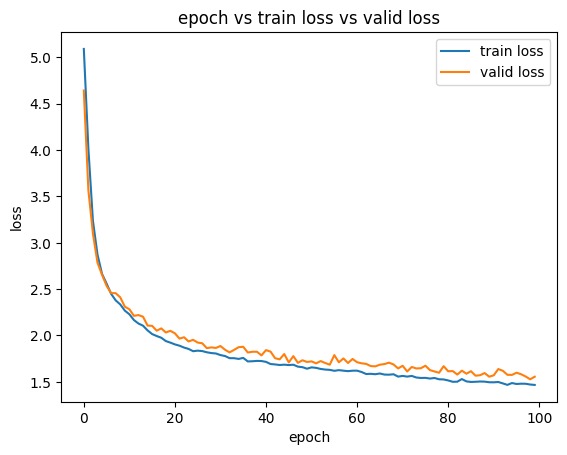

plot done


In [ ]:
train()

In [ ]:
predict()

/content/logbert/bert_pytorch/predict_log.py:230: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(self.model_path)
/content/logbert/bert_pytorch/predict_log

model_path: /content/drive/MyDrive/AmeXio/output/logbert/ApplicationServer_nlxdsmcv38/bert/best_bert.pth
test normal predicting


723it [00:00, 54534.17it/s]

test_normal size: 723



/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output["time_input"] = torch.tensor(output["time_input"], dtype=torch.float)
/content/logbert/bert_pytorch/dataset/log_dataset.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with nump

test_normal, #time anomaly: 0 # of undetected_tokens: 0, # of masked_tokens: 12 , # of total logkey 20, deepSVDD_label: 0 

test_normal, #time anomaly: 0 # of undetected_tokens: 0, # of masked_tokens: 15 , # of total logkey 20, deepSVDD_label: 0 

test_normal, #time anomaly: 0 # of undetected_tokens: 1, # of masked_tokens: 14 , # of total logkey 20, deepSVDD_label: 0 

test_normal, #time anomaly: 0 # of undetected_tokens: 0, # of masked_tokens: 18 , # of total logkey 20, deepSVDD_label: 0 

test_normal, #time anomaly: 0 # of undetected_tokens: 0, # of masked_tokens: 12 , # of total logkey 20, deepSVDD_label: 0 

test_normal, #time anomaly: 0 # of undetected_tokens: 0, # of masked_tokens: 8 , # of total logkey 20, deepSVDD_label: 0 

test_normal, #time anomaly: 0 # of undetected_tokens: 0, # of masked_tokens: 14 , # of total logkey 20, deepSVDD_label: 0 

test_normal, #time anomaly: 0 # of undetected_tokens: 0, # of masked_tokens: 15 , # of total logkey 20, deepSVDD_label: 0 

test_norm

0it [00:00, ?it/s]

test_abnormal size: 0


Saving test normal results
Saving test abnormal results
Saving test normal errors
Saving test abnormal results
best threshold: 0, best threshold ratio: 0
TP: 0, TN: 0, FP: 0, FN: 0
Precision: 0.00%, Recall: 0.00%, F1-measure: 0.00%
elapsed_time: 2.170858144760132
